## Install and Import Dependencies

In [1]:
!pip install imageio gdown

In [1]:
import os
import cv2
import imageio
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

In [2]:
# Check for GPU
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Completed")
except:
    pass

Completed


## Building Data Loading Functions

In [3]:
# import gdown

In [4]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [5]:
@tf.function(jit_compile=True, reduce_retracing=True)
def load_video(path:str) -> List[float]: 
    
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(f"The vocabulary is: {char_to_num.get_vocabulary()}")
print(f"size = {char_to_num.vocabulary_size()}")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
size = 40


In [9]:
def load_alignments(path: str) -> List[str]:
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), (-1)))[1:]

In [10]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [11]:
test_path = '.\\data\\s1\\bbal6n.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [12]:
frames, alignment = load_data(tf.convert_to_tensor(test_path))

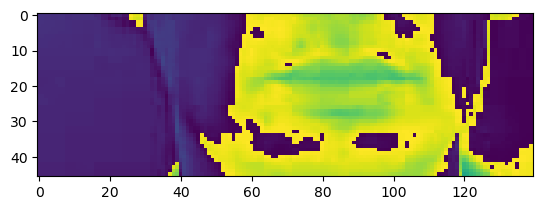

In [13]:
plt.imshow(frames[0])

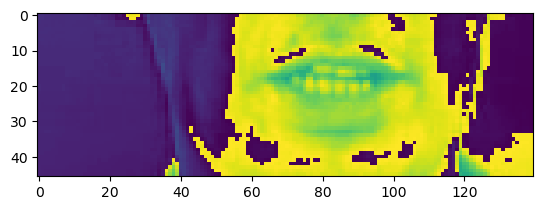

In [14]:
plt.imshow(frames[40])

In [15]:
num_to_char(alignment)

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'l', b' ', b's', b'i', b'x', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [16]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignment.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [17]:
def mappable_function(path: str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Creating a Data Pipeline

In [56]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
# added for split
test = data.take(5)
train = data.skip(5)

In [57]:
frames, alignment = data.as_numpy_iterator().next()

In [58]:
alignment

array([[ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8, 39, 21,
        39, 20,  8, 18,  5,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [12,  1, 25, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39,  6, 39, 26,
         5, 18, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [59]:
len(frames)

2

In [60]:
train_data = train.as_numpy_iterator()

In [61]:
test_data = test.as_numpy_iterator()

In [62]:
val = train_data.next(); val[0]

array([[[[[1.4466949 ],
          [1.4466949 ],
          [1.4466949 ],
          ...,
          [0.11128422],
          [0.44513687],
          [0.44513687]],

         [[1.4466949 ],
          [1.4466949 ],
          [1.4466949 ],
          ...,
          [0.14837895],
          [0.44513687],
          [0.40804213]],

         [[1.4096001 ],
          [1.4096001 ],
          [1.4096001 ],
          ...,
          [0.33385265],
          [0.33385265],
          [0.33385265]],

         ...,

         [[1.0757475 ],
          [1.0386527 ],
          [1.0386527 ],
          ...,
          [0.03709474],
          [0.03709474],
          [0.03709474]],

         [[1.0386527 ],
          [1.0386527 ],
          [1.0386527 ],
          ...,
          [0.07418948],
          [0.        ],
          [0.        ]],

         [[1.0386527 ],
          [1.0386527 ],
          [1.0386527 ],
          ...,
          [0.07418948],
          [0.        ],
          [9.459159  ]]],


        [[[1.4466

In [25]:
imageio.mimsave('./animation.gif', val[0][1], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.608295440673828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

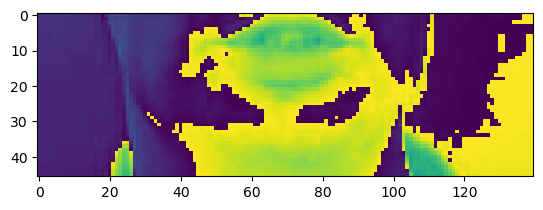

In [26]:
# getting the first frame of first video
plt.imshow(val[0][0][40])

In [27]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green by u two now'>

In [63]:
test_1 = test_data.next()

## Building the Deep Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
model = Sequential()

model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation="softmax"))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

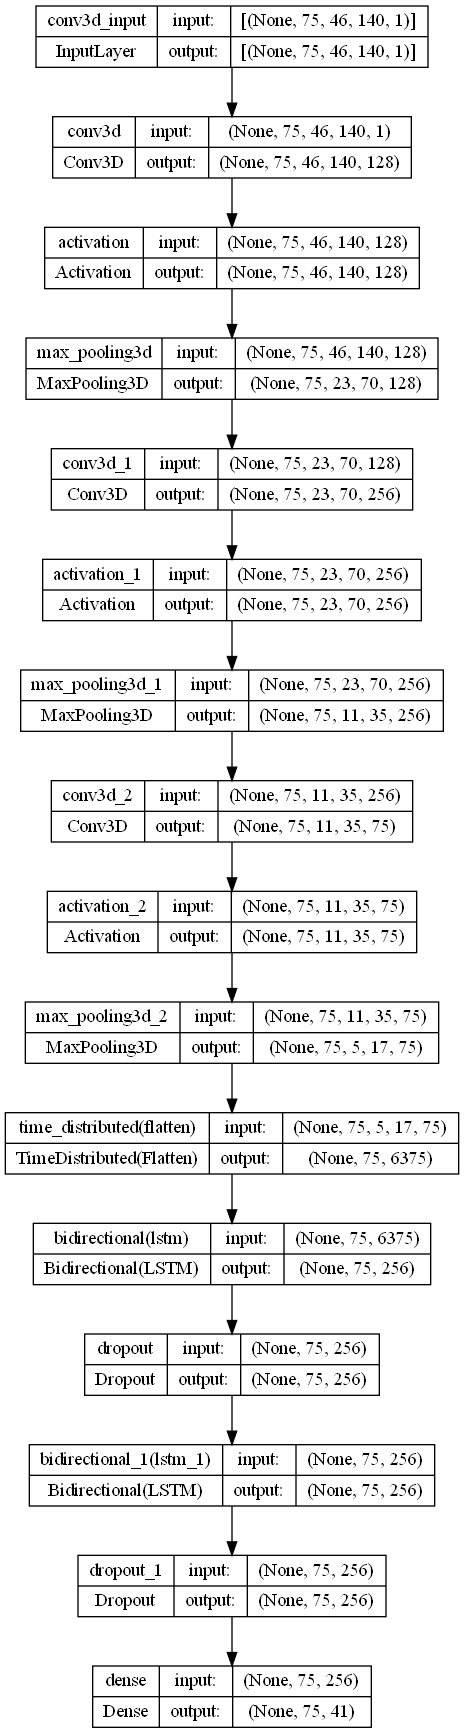

In [37]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [38]:
y_hat = model.predict(val[0])

1/1 [==============================] - 7s 7s/step


In [39]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in y_hat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'f3ffppppppppppppppttppppppppppppppppppppppppppppppppppppppptttpppp'>

In [40]:
tf.argmax(y_hat[0], axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([15, 15, 24, 24, 20, 30, 30, 30, 30, 30, 30, 30, 20, 20, 20, 20, 20,
       20, 20, 20, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20], dtype=int64)>

In [41]:
model.input_shape, model.output_shape

((None, 75, 46, 140, 1), (None, 75, 41))

## Training Setpup and Model-Training

In [42]:
def schedular(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [43]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [44]:
class ProductExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
        
    def on_epoch_end(self, epoch, log=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original: ', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction: ', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [45]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [46]:
ckp_cb = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)

In [47]:
schd_cb = LearningRateScheduler(schedular)

In [48]:
exmp_cb = ProductExample(data)

In [91]:
# Fitting the model on single epoch takes around 1hr so trained on colab and dowloaded the checkpoints
model.fit(data, 
          epochs=100, 
          validation_data = test,rl 
          callbacks=[ckp_cb, exmp_cb, schd_cb])

Epoch 1/100
  3/500 [..............................] - ETA: 1:15:36 - loss: 103.7840

KeyboardInterrupt: 

## Making a Prediction

In [93]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=3d6abe6a-a49c-4df3-be9c-23644349ed02
To: C:\Users\rajat\OneDrive\Desktop\Tensorflow\Lip Reading\checkpoints.zip
100%|█████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:08<00:00, 11.6MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [49]:
model.load_weights('models/checkpoint')

In [50]:
test

<TakeDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [51]:
test_1

(array([[[[[1.3907958 ],
           [1.3907958 ],
           [1.3907958 ],
           ...,
           [0.07726643],
           [0.07726643],
           [0.07726643]],
 
          [[1.3907958 ],
           [1.3907958 ],
           [1.3907958 ],
           ...,
           [0.07726643],
           [0.07726643],
           [0.07726643]],
 
          [[1.2362629 ],
           [1.2362629 ],
           [1.2362629 ],
           ...,
           [0.15453286],
           [0.11589965],
           [0.11589965]],
 
          ...,
 
          [[0.9271972 ],
           [0.9271972 ],
           [0.888564  ],
           ...,
           [9.696938  ],
           [9.735571  ],
           [9.735571  ]],
 
          [[0.9271972 ],
           [0.9271972 ],
           [0.888564  ],
           ...,
           [9.619671  ],
           [9.735571  ],
           [9.696938  ]],
 
          [[0.9271972 ],
           [0.9271972 ],
           [0.888564  ],
           ...,
           [9.619671  ],
           [9.696938  

In [70]:
test_1 = test_data.next()

In [71]:
yhat = model.predict(test_1[0])

1/1 [==============================] - 0s 435ms/step


In [72]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in test_1[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green with o four please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red in p one soon'>]

In [73]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)[0][0].numpy()

In [75]:
decoded

array([[ 2,  9, 14, 39,  7, 18,  5,  5, 14, 39, 23,  9, 20,  8, 39, 15,
        39,  6, 15, 21, 18, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [16, 12,  1,  3,  5, 39, 18,  5,  4, 39,  9, 14, 39, 16, 39, 15,
        14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=int64)

In [74]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green with o four please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red in p one soon'>]

## Test on Video

In [90]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [91]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [92]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 335ms/step


In [93]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [94]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]